In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [7]:
#import kaggle library
import kaggle

In [8]:
#call the kaggle authenticate API
kaggle.api.authenticate()

In [13]:
#downloadkaggle dataset of catfish sales from kaggle
kaggle.api.dataset_download_files('yekahaaagayeham/time-series-toy-data-set', path='data', unzip=True)

In [2]:
#create a date time parser function
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [15]:
#load the data
data = pd.read_csv('data\catfish.csv', header = 0, index_col = 0, parse_dates = [0], date_parser = parser, squeeze = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7012\3570494305.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv('data\catfish.csv', header = 0, index_col = 0, parse_dates = [0], date_parser = parser, squeeze = True)


In [16]:
#infer the frequency of the data
data.index.freq = data.index.inferred_freq

In [17]:
#view the data
data.head()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Freq: MS, Name: Total, dtype: int64

In [18]:
#view end of the data
data.tail()

Date
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, dtype: int64

In [19]:
#state the start and end date of the data
start_date = datetime(1996, 1, 1)
end_date = datetime(2000, 1, 1)

#set the limit of the data
lim_data = data[start_date:end_date]

In [20]:
#insert anaomaly at December 1 1998
lim_data[datetime(1998, 12, 1)] = 10000

<AxesSubplot: xlabel='Date'>

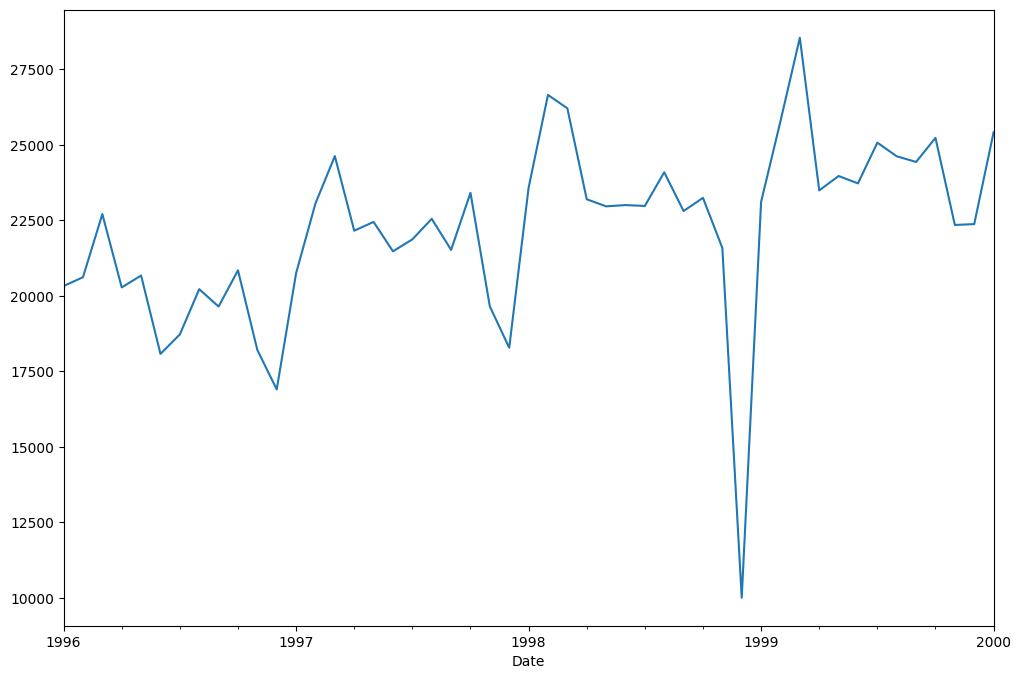

In [21]:
#plot the data
lim_data.plot(figsize = (12, 8))


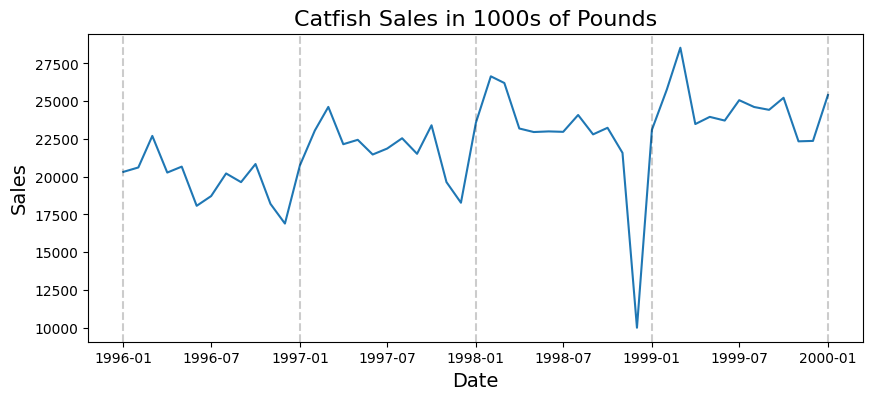

In [23]:
#plot the data
plt.figure(figsize = (10, 4))
plt.plot(lim_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [24]:
#remove the trend
lim_data_diff = lim_data.diff()[1:]

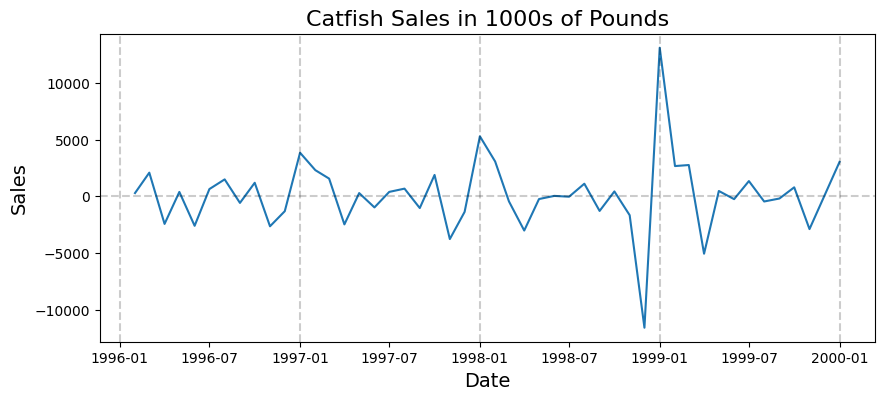

In [25]:
#plot the data
plt.figure(figsize = (10, 4))
plt.plot(lim_data_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)

#plot the vertical lines
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

#plot the horizontal lines
plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.2)

In [26]:
#get training and testing data
train_end = datetime(1999, 7, 1)
test_end = datetime(2000, 1, 1)

test_data = lim_data[train_end + timedelta(days = 1):test_end]

In [28]:
#initialize orders
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 1, 12)

In [29]:
#making predictions
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_data[:train_end - timedelta(days = 1)]
    model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
    results = model.fit()
    pred = results.get_forecast(steps = 1)
    rolling_predictions[train_end] = pred.predicted_mean[0]

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\DELL\anaconda3\lib\site-packages\

In [31]:
rolling_residuals = test_data - rolling_predictions

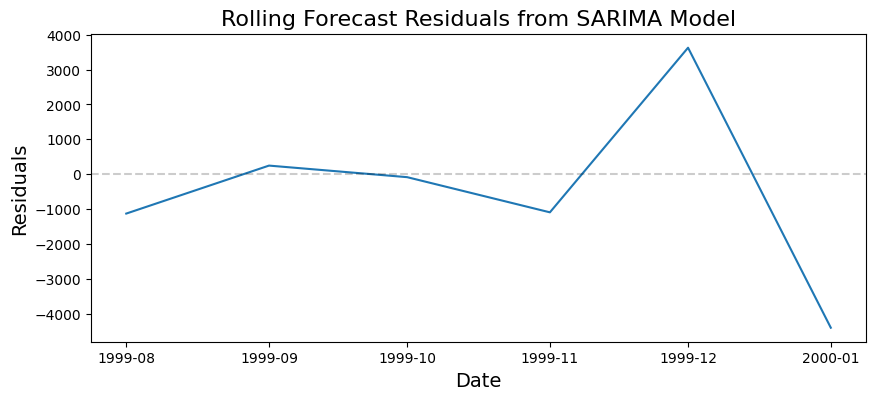

In [32]:
#plot the rolling residuals and the horizontal line
plt.figure(figsize = (10, 4))
plt.plot(rolling_residuals)
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Residuals', fontsize = 14)
plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.2)

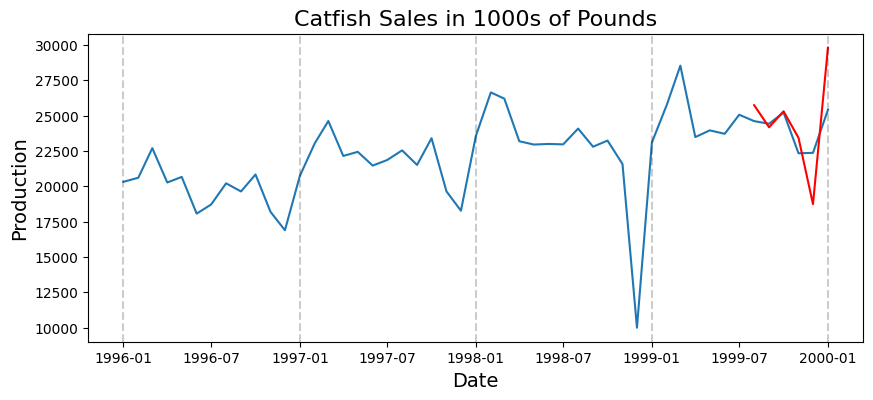

In [33]:
#superimpose the prediction upon the initial plot
plt.figure(figsize = (10, 4))
plt.plot(lim_data)
plt.plot(rolling_predictions, color = 'r')
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Production', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [35]:
#print the mean absolute percentage error
print('The Mean Absolute Percentage Error is: ', round(np.mean(np.abs(rolling_residuals/test_data)), 4))

The Mean Absolute Percentage Error is:  0.0739


In [36]:
#print the root mean squared error
print('The Root Mean Squared Error is: ', round(np.sqrt(np.mean(rolling_residuals**2)), 4))

The Root Mean Squared Error is:  2416.3715


Detecting the anomaly

# Attempt 1: Deviation Method

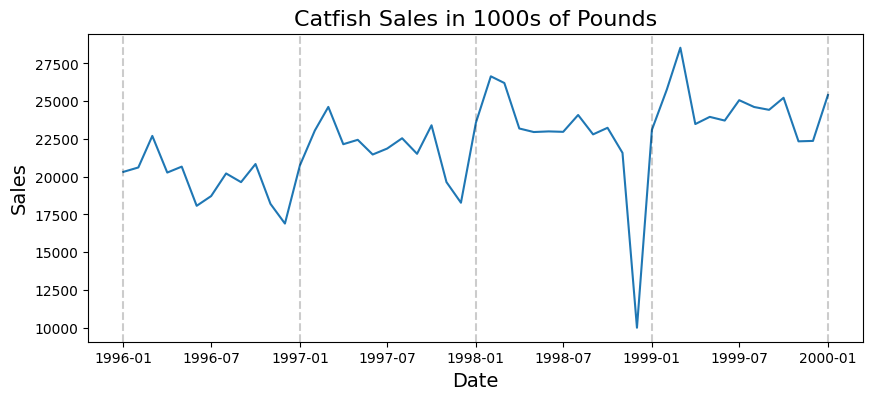

In [37]:
#plot the data
plt.figure(figsize = (10, 4))
plt.plot(lim_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [38]:
#initiate the rolling deviation variable
rolling_deviation = pd.Series(dtype = 'float64', index = lim_data.index)

In [39]:
#get the standard deviation of a window of data
for date in rolling_deviation.index:
    rolling_deviation[date] = lim_data[:date].std()

In [40]:
#get the difference between the rolling deviation and the next
rolling_deviation_diff = rolling_deviation.diff()[1:]
#drop missing of empty values
rolling_deviation_diff.dropna(inplace = True)

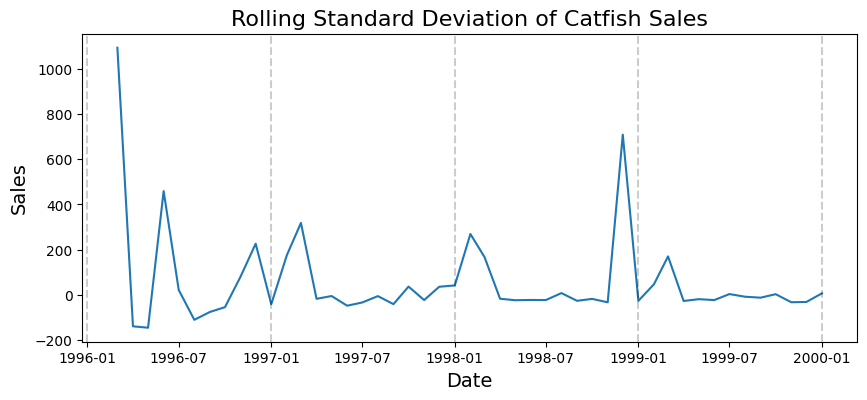

In [41]:
#plot the rolling deviation
plt.figure(figsize = (10, 4))
plt.plot(rolling_deviation_diff)
plt.title('Rolling Standard Deviation of Catfish Sales', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

# Attempt 2: Seasonal Method

In [42]:
#assign month deviation variable
month_deviation = lim_data.groupby(lambda x: x.month).std()

Text(0, 0.5, 'Sales')

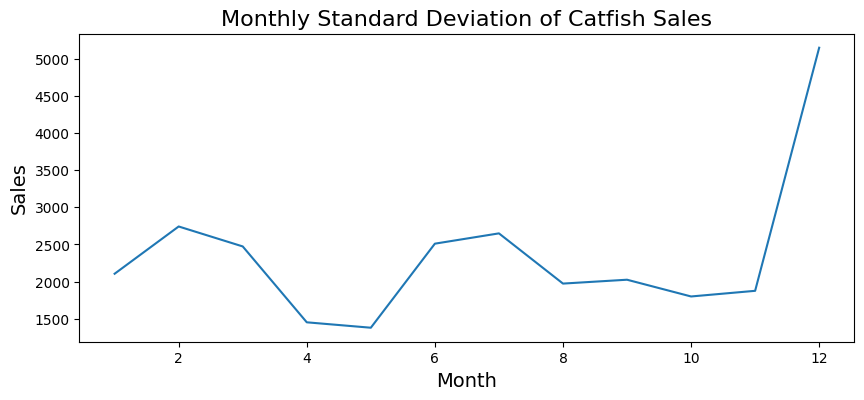

In [43]:
#plot the month deviation
plt.figure(figsize = (10, 4))
plt.plot(month_deviation)
plt.title('Monthly Standard Deviation of Catfish Sales', fontsize = 16)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)

So, we can see that the seasonal method is better than the deviation method.

In [44]:
#assign december deviation variable
december_data = lim_data[lim_data.index.month == 12]

In [45]:
december_data

Date
1996-12-01    16898
1997-12-01    18278
1998-12-01    10000
1999-12-01    22372
Name: Total, dtype: int64

In [46]:
#get the anomaly date
min_dev  = 999999999
curr_anomaly = None
#iterate through the december data
for date in december_data.index:
    #set other dates in the periods to a variable
    other_data = december_data[december_data.index != date]
    #get the deviation
    curr_dev = other_data.std()
    #check if the deviation is less than the minimum
    if curr_dev < min_dev:
        #update the minimum
        min_dev = curr_dev
        #update the anomaly date
        curr_anomaly = date

#print the anomaly date
print('The anomaly date is: ', curr_anomaly)

The anomaly date is:  1998-12-01 00:00:00


Possible Actions:

# Use mean of other months

In [49]:
#get the mean of other months
adjusted_data= lim_data.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

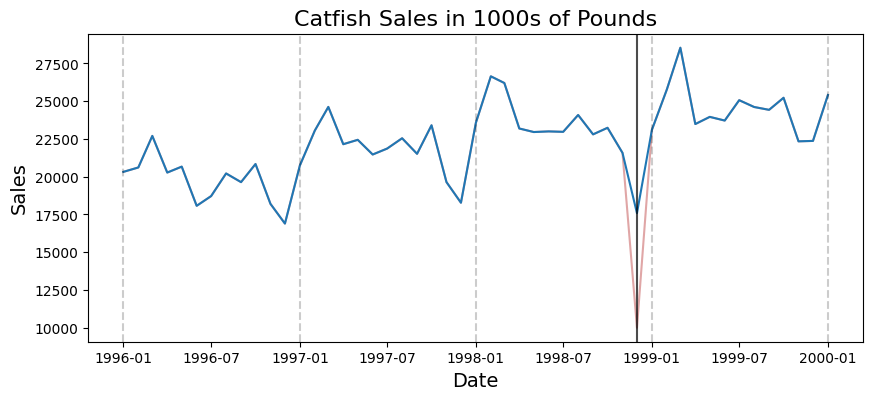

In [50]:
#plot the adjusted data
plt.figure(figsize = (10, 4))
plt.plot(lim_data, color = 'firebrick', alpha = 0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Sales', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)
plt.axvline(curr_anomaly, color = 'k', alpha = 0.7)

Resulting Predictions:

In [51]:
#assign the training and testing data
train_end = datetime(1999, 7, 1)
test_end = datetime(2000, 1, 1)

test_data = adjusted_data[train_end + timedelta(days = 1):test_end]

In [61]:
#assign the rolling prediction variable
rolling_predictions = test_data.copy()

#iterate through the test data
for train_end in test_data.index:
    #get the train data
    train_data = adjusted_data[:train_end - timedelta(days = 1)]
    #get the model
    model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order)
    #fit the model
    results = model.fit()
    #get the prediction
    pred = results.get_forecast(steps = 1)
    #update the rolling predictions
    rolling_predictions[train_end] = pred.predicted_mean

c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\

In [56]:
test_data

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64

In [62]:
rolling_predictions

Date
1999-08-01    25822.594576
1999-09-01    23957.485738
1999-10-01    25236.059443
1999-11-01    23373.807357
1999-12-01    20795.447075
2000-01-01    27721.110335
Freq: MS, Name: Total, dtype: float64

In [63]:
#assign the rolling residuals variable
rolling_residuals = test_data - rolling_predictions

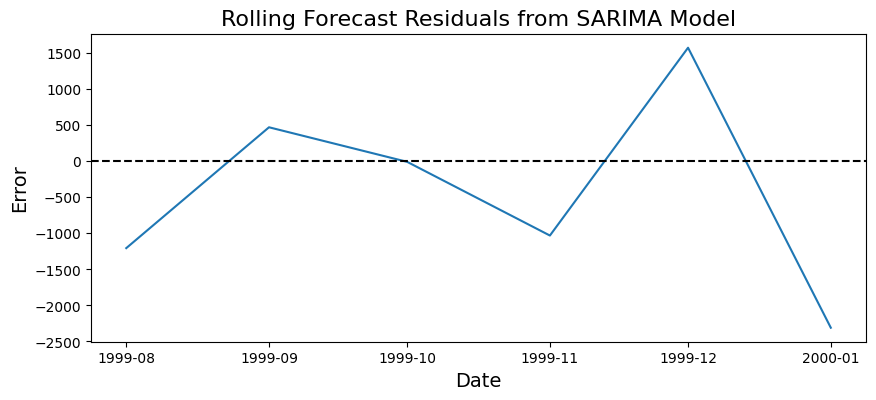

In [65]:
#plot the rolling residuals
plt.figure(figsize = (10, 4))
plt.plot(rolling_residuals)
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.axhline(0, color = 'k', linestyle = '--')


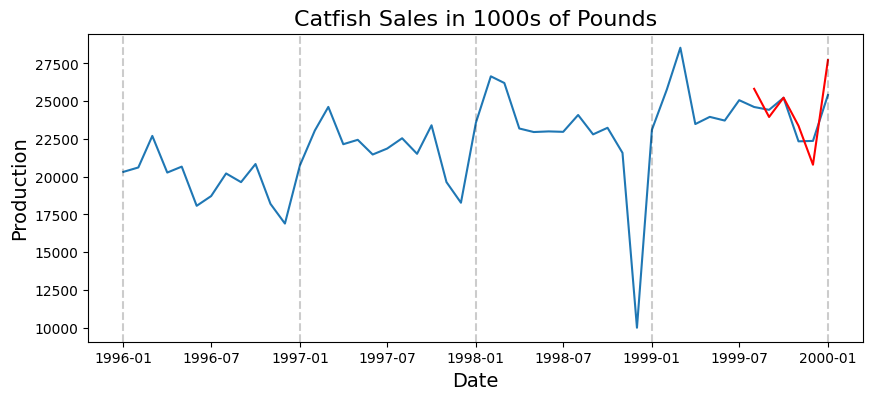

In [66]:
#plot the rolling predictions
plt.figure(figsize = (10, 4))
plt.plot(lim_data)
plt.plot(rolling_predictions, color = 'r')
plt.title('Catfish Sales in 1000s of Pounds', fontsize = 16)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Production', fontsize = 14)
for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'k', linestyle = '--', alpha = 0.2)

In [67]:
#print the mean absolute percentage error
print('The Mean Absolute Percentage Error is: ', round(np.mean(np.abs(rolling_residuals/test_data)), 4))

The Mean Absolute Percentage Error is:  0.046


In [69]:
#print the root mean squared error
print('The Root Mean Squared Error is: ', round(np.sqrt(np.mean(rolling_residuals**2)), 2))

The Root Mean Squared Error is:  1326.17
